In [12]:
from __future__ import print_function
import os
import tree_kernel
from tree_kernel import Tree, parse, \
    TreeKernel, TreeKernel2, \
    TreeKernel3, TreeKernel4,load_parses
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
DATA = os.path.abspath('./data')
parse_Ax = os.path.join(DATA, 'parse_Ax.txt')
parse_Bx = os.path.join(DATA, 'parse_Bx.txt')
parses_A, parses_B = load_parses(parse_Ax, parse_Bx)

In [14]:
def progress_bar(percent, txt):
    """Prints the progress until the next report."""
    fill = int(percent * 40)
    print("\r[{}{}]: {:.4f} {:s}".format(
        "=" * fill, " " * (40 - fill), percent, txt), end='')

In [4]:
tk = TreeKernel(lam=10, nnodes=300)
cos_lst = []
for i, (parse_A, parse_B) in enumerate(zip(parses_A, parses_B)):
        tree_A = Tree(lam = 1)
        tree_B = Tree(lam = 1)
        parse(parse_A, tree_A)
        parse(parse_B, tree_B)
        cos_val = tk.cos(tree_A, tree_B)
        cos_lst.append(cos_val)
        percent = (i+.0)/len(parses_A)
        progress_bar(percent, 'loading...')

[======================================= ]: 1.0000 loading...

In [5]:
data = pd.read_csv(os.path.join(DATA, 'label.txt'), 
            names=['label'], header=None)
data['cos'] = cos_lst
data.iloc[:10]

,label,cos
0,1,0.986706
1,0,1.467799
2,0,1.240952
3,0,2.019125
4,0,0.237564
5,0,1.241755
6,0,2.159091
7,0,0.575650
8,0,1.132452
9,0,1.157278


In [6]:
valid_index = np.load(os.path.join(DATA, 'valid_index.npy'))
train_index = list(set(valid_index)^set(data.index))
train = data.iloc[train_index]
valid = data.iloc[valid_index]

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'cos')

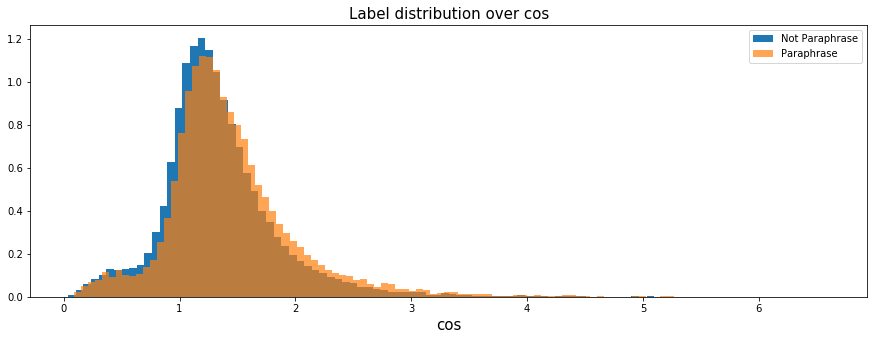

In [7]:
plt.figure(figsize=(15, 5))
plt.hist((train['cos'])[train['label'] == 0], bins=100, normed=True, label='Not Paraphrase')
plt.hist((train['cos'])[train['label'] == 1], bins=100, normed=True, alpha=0.7, label='Paraphrase')
plt.legend()
plt.title('Label distribution over cos', fontsize=15)
plt.xlabel('cos', fontsize=15)

In [8]:
n_np = (train[train['label'] == 0].count())['label']
n_p = (train[train['label'] == 1].count())['label']

In [9]:
train[train['label'] == 0].sum()['cos']/n_np

1.334828119538693

In [10]:
train[train['label'] == 1].sum()['cos']/n_p

1.4345915146570136

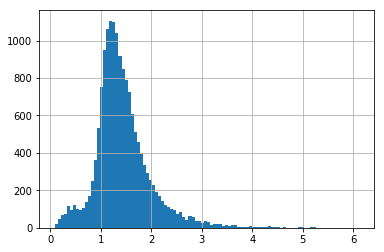

In [11]:
train[train['label'] == 1]['cos'].hist(bins = 100)

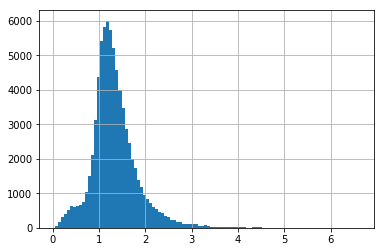

In [12]:
train[train['label'] == 0]['cos'].hist(bins = 100)

In [13]:
hist_p = np.histogram(train[train['label'] == 1]['cos'],
                      bins=len(train), )
bin_lst = hist_p[1]
hist_np = np.histogram(train[train['label'] == 0]['cos'], 
                       bins=bin_lst, )

In [14]:
def equals(x, y, e):
    print(np.abs(x-y))
    return np.abs(x-y) < e

In [15]:
sum_p = hist_p[0].sum() + .0
sum_np = hist_np[0].sum() + .0
prior_p = n_p/(n_p + n_np + .0)
prior_np = n_np/(n_p + n_np + .0)
deltas = []
for i, bin_val in enumerate(bin_lst):
    llh_np = hist_np[0][:i].sum()/sum_np # <
    llh_p = hist_p[0][i:].sum()/sum_p # >=
    post_np = llh_np * prior_np
    post_p = llh_p * prior_p
    delta = np.abs(post_np - post_p)
    deltas.append(delta)

idx_min = deltas.index(np.min(deltas))
print(deltas[idx_min], bin_lst[idx_min])

2.87454565656986e-05 0.9855599003200559


In [16]:
cos_sep = bin_lst[idx_min]
pred = valid['cos']
true = valid['label']
pred = pred.apply(lambda x: 1 if x >= cos_sep else 0)
print(f1_score(true, pred), 
      precision_score(true, pred), 
      recall_score(true, pred))

0.368333023601561 0.23450070989115002 0.858008658008658


In [20]:
def f1(kernel='TreeKernel2', lam=0.5):
    tk = None
    if kernel == 'TreeKernel':
        tk = TreeKernel(lam=lam, nnodes=300) 
    elif kernel == 'TreeKernel2':
        tk = TreeKernel2(lam=lam, nnodes=300)
    elif kernel == 'TreeKernel3':
        tk = TreeKernel3(lam=lam, nnodes=300)
    else:
        tk = TreeKernel4(lam=lam, nnodes=300)
        
    cos_lst = []
    for i, (parse_A, parse_B) in enumerate(zip(parses_A, parses_B)):
            tree_A = Tree(lam = 1)
            tree_B = Tree(lam = 1)
            parse(parse_A, tree_A)
            parse(parse_B, tree_B)
            cos_val = tk.cos(tree_A, tree_B)
            cos_lst.append(cos_val)
            percent = (i+.0)/len(parses_A)
            progress_bar(percent, 'loading...')
    
    data = pd.read_csv(os.path.join(DATA, 'label.txt'), 
            names=['label'], header=None)
    data['cos'] = cos_lst
    
    valid_index = np.load(os.path.join(DATA, 'valid_index.npy'))
    train_index = list(set(valid_index)^set(data.index))
    train = data.iloc[train_index]
    valid = data.iloc[valid_index]
    
    n_np = (train[train['label'] == 0].count())['label']
    n_p = (train[train['label'] == 1].count())['label']

    hist_p = np.histogram(train[train['label'] == 1]['cos'],
                      bins=len(train), )
    bin_lst = hist_p[1]
    hist_np = np.histogram(train[train['label'] == 0]['cos'], 
                           bins=bin_lst, )
    
    sum_p = hist_p[0].sum() + .0
    sum_np = hist_np[0].sum() + .0
    prior_p = n_p/(n_p + n_np + .0)
    prior_np = n_np/(n_p + n_np + .0)
    deltas = []
    for i, bin_val in enumerate(bin_lst):
        llh_np = hist_np[0][:i].sum()/sum_np # <
        llh_p = hist_p[0][i:].sum()/sum_p # >=
        post_np = llh_np * prior_np
        post_p = llh_p * prior_p
        delta = np.abs(post_np - post_p)
        deltas.append(delta)

    idx_min = deltas.index(np.min(deltas))
    cos_sep = bin_lst[idx_min]
    pred = valid['cos']
    true = valid['label']
    pred = pred.apply(lambda x: 1 if x >= cos_sep else 0)

    print('Report: kernel %s lam %f f1 %f prec %f recall %f' %
          (kernel,
           lam,
           f1_score(true, pred), 
           precision_score(true, pred), 
           recall_score(true, pred)))

In [21]:
for i in range(1,10):
    lam = i * 0.1
    f1(kernel='TreeKernel2', lam=lam)

[======================================= ]: 1.0000 loading...Report: kernel TreeKernel2 lam 0.100000 f1 0.370370 prec 0.235894 recall 0.861472
[======================================= ]: 1.0000 loading...Report: kernel TreeKernel2 lam 0.200000 f1 0.370233 prec 0.235782 recall 0.861472
[======================================= ]: 1.0000 loading...Report: kernel TreeKernel2 lam 0.300000 f1 0.369689 prec 0.235406 recall 0.860606
[=====                                   ]: 0.1384 loading...

KeyboardInterrupt: 